In [1]:
%load_ext autoreload
%autoreload 1
%aimport my, net, models, data

import sys
import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
import importlib
import pickle

import my
from my import p
import net, data
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
     
dir_out = "out/"
dir_data = 'data/'

RANDOM_STATE = 34
np.random.seed(RANDOM_STATE)
N_CPU = os.cpu_count()

In [2]:
df = pd.read_csv(dir_data+'train.csv')
df_test = pd.read_csv(dir_data+'test.csv')
p(df.shape, df_test.shape)
df[:3]

(63438, 5)
 ~
(29960, 4)


,id,word,stress,num_syllables,lemma
0,0,румяной,2,3,румяный
1,1,цифрами,1,3,цифра
2,2,слугами,1,3,слуга


In [3]:
known_cases = df['word'].str.contains('ё') | (df['num_syllables'] == 1)
df = df[~known_cases].reset_index(drop=True).copy()
df.shape

(61422, 5)

In [4]:
N_FOLDS = 5
df = my.add_folds(df,n_folds=N_FOLDS, random_state=RANDOM_STATE)

In [5]:
# https://docs.wandb.ai/ref/app/features/panels/code#save-library-code
import IPython
os.environ['WANDB_NOTEBOOK_NAME'] = IPython.extract_module_locals()[1]['__vsc_ipynb_file__']

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(name='final2',project='accent')

In [13]:
from lightning.pytorch.callbacks import EarlyStopping, TQDMProgressBar, ModelCheckpoint, StochasticWeightAveraging
import lightning as pl
net.set_seed(RANDOM_STATE)

FOLD = 0
EXP = 1
CHECKPOINT_DIR = 'ckpts/'
NAME_CKPT = f'exp_{EXP}-f_{FOLD}'+'-epoch_{epoch:02d}-val_acc_{val_acc:.3f}'

es = EarlyStopping('val_acc',patience=15,verbose=True,mode='max')
tq = TQDMProgressBar(refresh_rate=10)
chpt = ModelCheckpoint(dirpath=CHECKPOINT_DIR,filename=NAME_CKPT,  monitor="val_acc",mode='max',auto_insert_metric_name=False)
# swa = StochasticWeightAveraging(swa_lrs=1e-2)


dm = data.DataModule(df,df_test,fold=FOLD,collate_type='pack', batch_size=64)
model = net.Model(lr=0.001)
wandb_logger.watch(model)
trainer = pl.Trainer(callbacks=[tq,es,chpt],max_epochs=1000,deterministic = True,logger=wandb_logger)

Global seed set to 34
/root/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


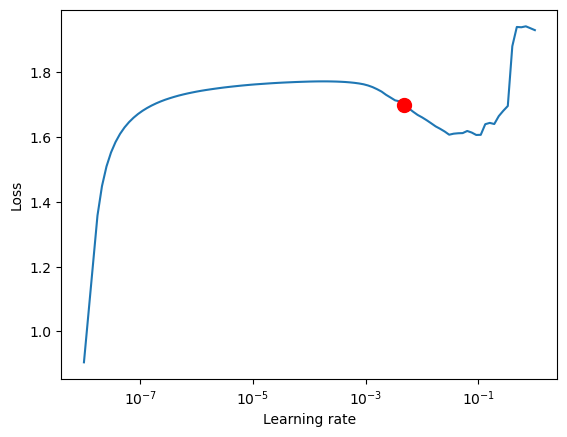

In [11]:
lr_finder = trainer.tuner.lr_find(model,dm)
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr

fig = lr_finder.plot(suggest=True)
fig.show()

In [14]:
trainer.fit(model, datamodule=dm)
wandb.finish()

/root/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /root/PROJECTS/NOW/ACCENT/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Gru_Pack_final     | 4.1 M 
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
4.1 M     Trainable params
238       Non-trainable params
4.1 M     Total params
16.366    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/root/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.750


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.790


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.810


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.815


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.830
/root/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_acc,▁▅▆▇█
train_loss,█▇▄▅▅▄▅▄▄▃▄▃▅▃▄▂▁▂▂▃▃▂▁▃▂▂▂▂▂▂▂▃▂▂▂▁▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,0.86845
train_loss,0.22237
trainer/global_step,3824
val_acc,0.83016
